In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Full data set will be cleaned up prior to splitting into train, test and final.

Put completed_loans_2017.csv file in ./Data/ for this notebook to run.

# Initial Data Load and Clean Up

In [2]:
data = pd.read_csv('./Data/completed_loans_2017.csv', low_memory=0)

In [3]:
rows, columns = data.shape
data.shape

(263720, 150)

150 columns, just over 1/4 million lines.

In [4]:
missing_values = pd.DataFrame((data.isnull().sum()/rows)* 100, columns=["% Missing Values"])
missing_values["Missing_Values"] = missing_values["% Missing Values"] > 0
cols_with_missing_values = missing_values[missing_values.Missing_Values].index
missing_values[missing_values.Missing_Values].describe()

,% Missing Values
count,62.000000
mean,66.972259
std,42.121467
min,0.000379
25%,7.883930
50%,92.705521
75%,99.137722
max,100.000000


62 columns with missing values with some up to 100% missing.

In [5]:
data.loan_status = (data.loan_status == "Charged Off").astype('int8')

In [6]:
data.loan_status.mean()

0.23006977096920977

Default rate is 23%

In [7]:
non_numerical_columns = data.columns[data.dtypes=="object"]
non_numerical_columns.shape

(35,)

There are 35 columns that are not numerical, some may be formatting, others will need encoding.

In [8]:
non_nums = (data[non_numerical_columns][70:74].T)
non_nums['unique'] = data[non_numerical_columns].nunique()
non_nums.sort_values('unique', ascending=0)


,70,71,72,73,unique
url,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,263720
emp_title,VIP Art Associate,Court Liaison,Senior Account Manager,Machine Operator,79726
revol_util,81.5%,95.2%,84.3%,11.2%,1117
zip_code,113xx,088xx,640xx,372xx,891
earliest_cr_line,Jan-2002,Mar-1991,Apr-2002,May-2007,666
sec_app_earliest_cr_line,NaN,NaN,NaN,NaN,566
int_rate,11.49%,14.99%,14.99%,23.99%,67
addr_state,NY,NJ,MO,TN,50
last_credit_pull_d,Nov-2018,Jan-2019,May-2018,Jan-2020,39
last_pymnt_d,Jun-2018,Feb-2019,May-2018,Feb-2019,38


There are a few columns that are dates and % which can be enumerated.

In [9]:
pctstr_cols = ['int_rate', 'revol_util']
datestr_cols = ['issue_d','earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',\
                'settlement_date','payment_plan_start_date','hardship_end_date',\
               'debt_settlement_flag_date','hardship_start_date','sec_app_earliest_cr_line']
def pcent_to_float(df, col):
    return df[df[col].notnull()][col].apply(lambda x: (str(x)[:-1])).astype('float16')
def date_to_int(df, col):
    return ((pd.to_datetime(df[df[col].notnull()][col]) - pd.to_datetime(df[df[col].notnull()][col]).min())/ (10**11)).astype('int64').astype('int32')

url is just link to the loan page and emp_title has too much dimensionality to be of use with this data set so will be removed.

In [10]:
non_numerical_columns = list(set(non_numerical_columns) - set(pctstr_cols) - set(datestr_cols))
remove_cols = [non_numerical_columns.pop(non_numerical_columns.index('url'))]
remove_cols.append(non_numerical_columns.pop(non_numerical_columns.index('emp_title')))

In [11]:
remove_cols.append('id')
remove_cols.append('Unnamed: 0')


In [12]:
non_numerical_columns

['hardship_flag',
 'term',
 'initial_list_status',
 'zip_code',
 'hardship_reason',
 'home_ownership',
 'hardship_type',
 'verification_status_joint',
 'addr_state',
 'application_type',
 'verification_status',
 'debt_settlement_flag',
 'settlement_status',
 'pymnt_plan',
 'hardship_status',
 'grade',
 'hardship_loan_status',
 'purpose',
 'sub_grade',
 'emp_length',
 'title']

In [13]:
del data

# Train Test Final Clean Up

In [127]:
# train = pd.read_csv('Data/train.csv')
train = pd.read_csv('train_2014.csv')
test = pd.read_csv('test_2014.csv')
final = pd.read_csv('final_2014.csv')
files = [train, test, final]

In [128]:
non_numerical_columns = list(set(non_numerical_columns)-
                             set(['hardship_flag', 'hardship_type', 'pymnt_plan']))

In [129]:
for file in files:
    for col in pctstr_cols:
        file[col] = pcent_to_float(file, col)
    for col in datestr_cols:
        file[col] = date_to_int(file, col)
    file.drop(remove_cols, axis = 1, inplace=True)


In [130]:
le = LabelEncoder()

In [131]:
for file in files:
    for col in non_numerical_columns:
        le.fit(file[col].astype('str'))
        file[col] = le.transform(file[col].astype('str'))

# Variable Importance from RF

In [132]:
y_train = train.loan_status
y_test = test.loan_status
y_final = final.loan_status
X_train = train.drop('loan_status', axis=1)
X_test = test.drop('loan_status', axis=1)
X_final = final.drop('loan_status', axis=1)

In [134]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [21]:
fitrf = RandomForestClassifier(n_estimators = 500, oob_score = True, min_samples_leaf = 10)

In [28]:
top = [X_features[i] for i in indices][-35:]
top.reverse()
definitions = pd.read_excel('./Data/LCDataDictionary.xlsx', index_col=0)
topdef = definitions.loc[top]
topdef

,Description
LoanStatNew,
last_fico_range_high,The upper boundary range the borrower’s last F...
last_fico_range_low,The lower boundary range the borrower’s last F...
collection_recovery_fee,post charge off collection fee
last_pymnt_amnt,Last total payment amount received
recoveries,post charge off gross recovery
total_rec_prncp,Principal received to date
total_pymnt,Payments received to date for total amount funded
total_pymnt_inv,Payments received to date for portion of total...
funded_amnt,The total amount committed to that loan at tha...


In [29]:
(topdef.loc[top]).index

Index(['last_fico_range_high', 'last_fico_range_low',
       'collection_recovery_fee', 'last_pymnt_amnt', 'recoveries',
       'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt',
       'loan_amnt', 'funded_amnt_inv', 'installment', 'debt_settlement_flag',
       'settlement_status', 'last_pymnt_d', 'total_rec_int', 'settlement_date',
       'settlement_term', 'debt_settlement_flag_date', 'settlement_percentage',
       'settlement_amount', 'total_rec_late_fee', 'sub_grade',
       'last_credit_pull_d', 'int_rate', 'term', 'grade', 'issue_d',
       'hardship_last_payment_amount', 'revol_bal', 'fico_range_high',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_dpd'],
      dtype='object', name='LoanStatNew')

In [30]:
post_hoc =['last_fico_range_high', 'last_fico_range_low', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'total_rec_prncp',
       'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'funded_amnt_inv', 'debt_settlement_flag',
       'settlement_term', 'last_pymnt_d', 'total_rec_int',
       'settlement_percentage', 'debt_settlement_flag_date', 'settlement_date',
       'settlement_amount', 'total_rec_late_fee', 'settlement_status',
       'last_credit_pull_d','hardship_amount', 'payment_plan_start_date',
       'hardship_dpd', 'hardship_payoff_balance_amount',
       'hardship_last_payment_amount']

In [31]:
vars_ = set(topdef.index) - set(post_hoc)

In [32]:
X_train_2 = X_train.drop(post_hoc, axis = 1)

In [33]:
fitrf_2 = RandomForestClassifier(n_estimators = 1000, oob_score = True, min_samples_leaf = 10)

In [34]:
fitrf_2.fit(X_train_2, y_train)
None

In [35]:
X_features = list(X_train_2.columns)
rf_importances = fitrf_2.feature_importances_


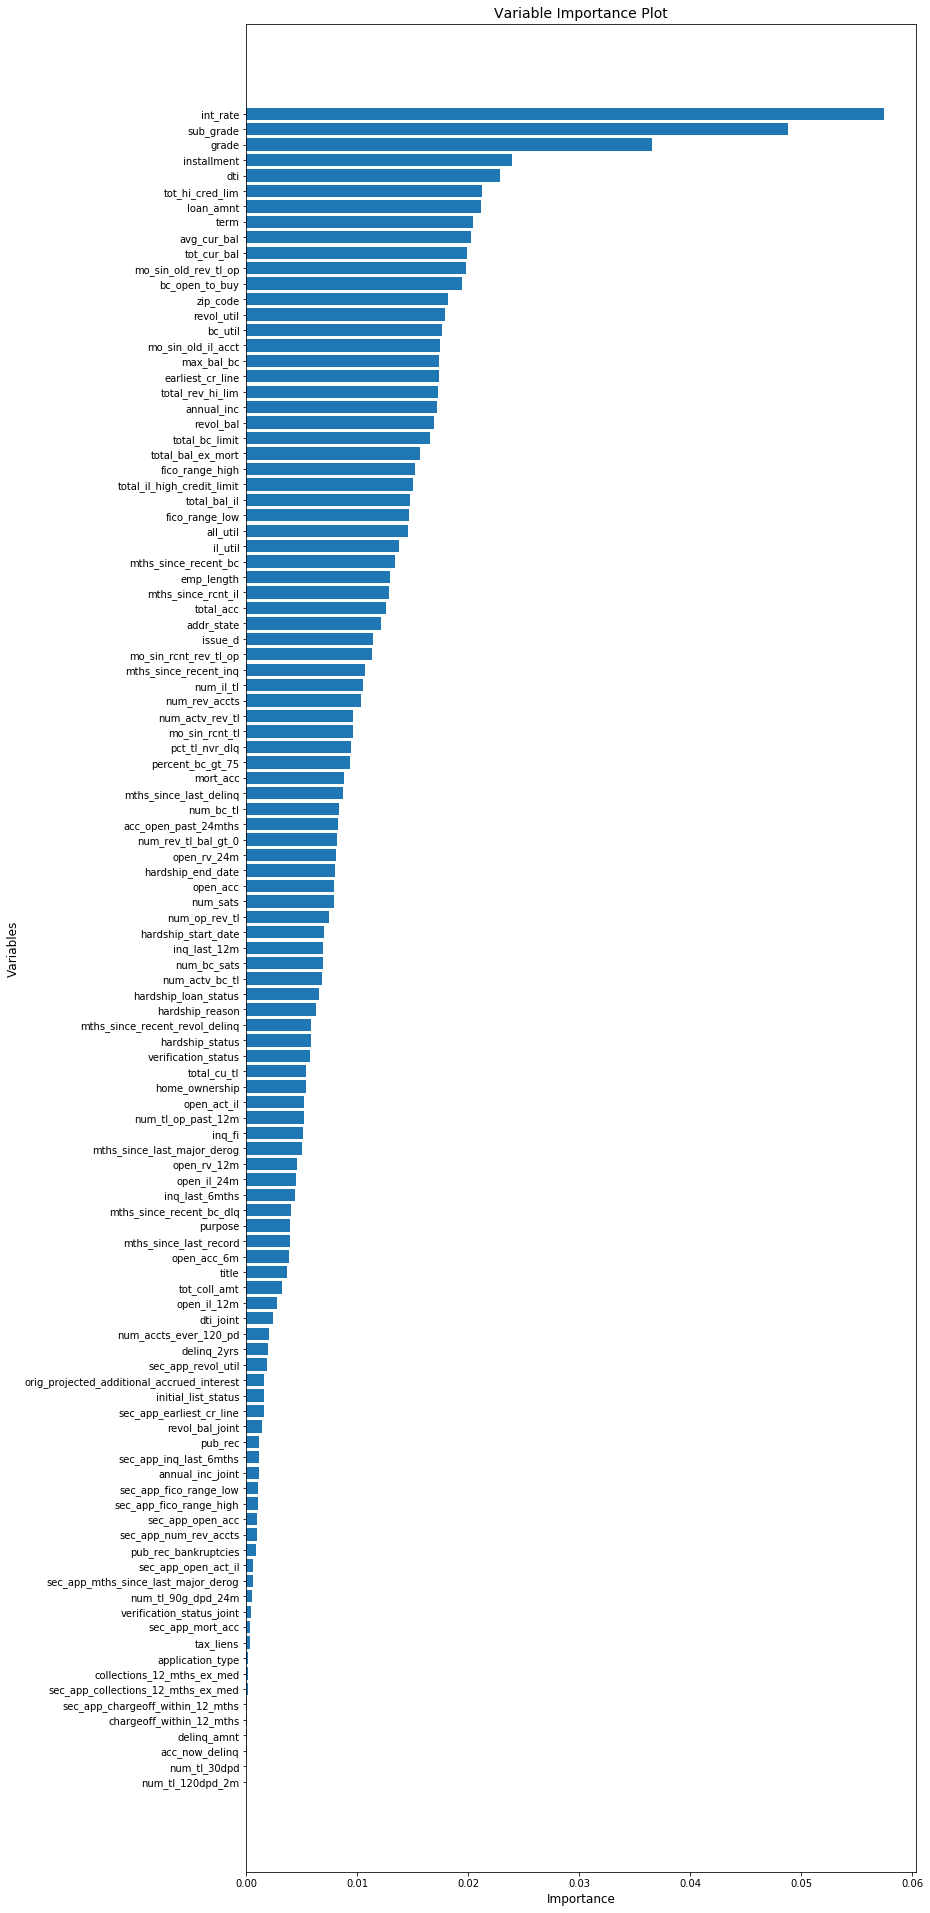

In [36]:
indices = np.argsort(rf_importances)

fig = plt.figure(figsize=[12,34])
axs = fig.subplots(1,1)
plt.yticks(range(len(indices)), [X_features[i] for i in indices])
axs.barh(range(len(indices)), rf_importances[indices], align='center')
axs.set_title("Variable Importance Plot", size ='14')
axs.set_ylabel("Variables", size='12'); axs.set_xlabel("Importance", size='12')
None

In [147]:
not_posthoc = pd.read_excel('LCDataDictionary.xlsx', index_col=0)
not_posthoc.columns

Index(['Description', 'posthoc(0=N,1=Y,2=M)'], dtype='object')

In [146]:
selected_cols = list(not_posthoc[not_posthoc['posthoc(0=N,1=Y,2=M)']==0.0].iloc[:,0].index)

In [148]:
X_train.drop(set(X_train.columns) - set(selected_cols), inplace=True, axis=1)

In [149]:
X_train.columns

Index(['member_id', 'loan_amnt', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'mths_since_last_record', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'initial_list_status', 'policy_code',
       'application_type', 'annual_inc_joint', 'dti_joint', 'tot_coll_amt',
       'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'num_accts_ever_120_pd', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object')

In [163]:
fitrf_2 = RandomForestClassifier(n_estimators = 200, oob_score = True, min_samples_leaf = 10)

In [164]:
fitrf_2.fit(X_train, y_train)
None

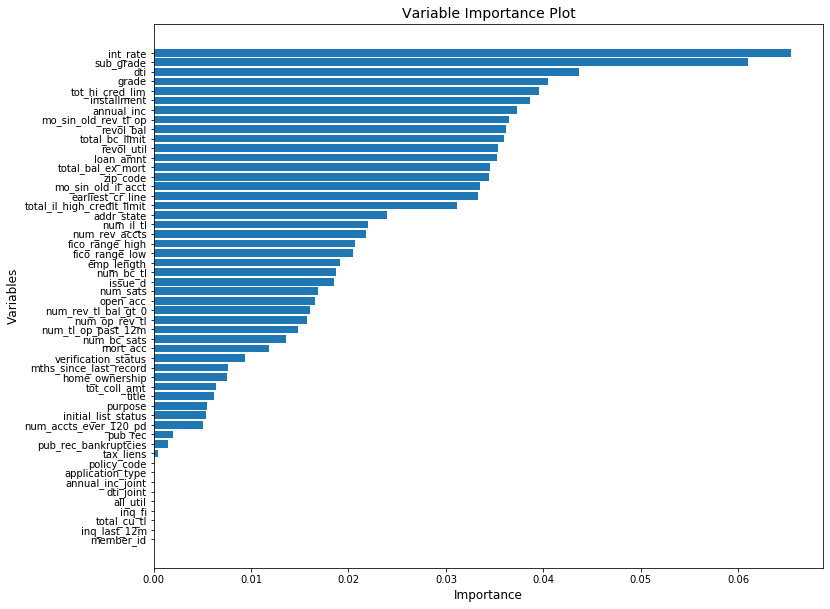

In [165]:
X_features = list(X_train.columns)
rf_importances = fitrf_2.feature_importances_
indices = np.argsort(rf_importances)

fig = plt.figure(figsize=[12,10])
axs = fig.subplots(1,1)
plt.yticks(range(len(indices)), [X_features[i] for i in indices])
axs.barh(range(len(indices)), rf_importances[indices], align='center')
axs.set_title("Variable Importance Plot", size ='14')
axs.set_ylabel("Variables", size='12'); axs.set_xlabel("Importance", size='12')
None


In [153]:
X_test.drop(set(X_test.columns) - set(selected_cols), inplace=True, axis=1)

In [154]:
X_test.isnull().sum()

member_id                     0
loan_amnt                     0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
mths_since_last_record        0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
initial_list_status           0
policy_code                   0
application_type              0
annual_inc_joint              0
dti_joint                     0
tot_coll_amt                  0
all_util                      0
inq_fi  

In [167]:
y_hat = fitrf_2.predict(X_test)

In [168]:
(y_test == y_hat).mean()

0.8252344777829648

In [169]:
1-y_test.mean()

0.8249374018588465